<a href="https://colab.research.google.com/github/GaoangLiu/ipynb/blob/master/NLP_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP with Disaster Tweets

Kaggle contest page: https://www.kaggle.com/c/nlp-getting-started/overview

Task: predicts which Tweets are about real disasters and which one’s aren’t. Return value is either 1 (real) or 0 (unreal) .


In [1]:
# Load packages 
import math
import re
import os
import timeit
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import logging
import time

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
logging.basicConfig(format='[%(asctime)s %(levelname)8s] %(message)s', level=logging.INFO, datefmt='%m-%d %H:%M:%S')

from keras import layers, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
[05-13 03:28:35     INFO] 'pattern' package not found; tag filters are not available for English


## Explore data


In [55]:
! wget -O tweets.zip ali.140714.xyz:8000/nlp-getting-started.zip 
! unzip tweets.zip 
! ls
! wget -O labels.csv ali.140714.xyz:8000/leaked_tweet_labels.csv


--2020-05-13 05:59:28--  http://ali.140714.xyz:8000/leaked_tweet_labels.csv
Resolving ali.140714.xyz (ali.140714.xyz)... 47.240.16.188
Connecting to ali.140714.xyz (ali.140714.xyz)|47.240.16.188|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22746 (22K) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]  22.21K   131KB/s    in 0.2s    

2020-05-13 05:59:28 (131 KB/s) - ‘labels.csv’ saved [22746/22746]



In [3]:
train = pd.read_csv('train.csv')
train.target.value_counts() 
""" 
0    4342
1    3271
Name: target, dtype: int64
Good, so the data is WELL balanced
"""
train.keyword.value_counts()
train.text.str.len().nsmallest(30)

1882     7
4890     7
5115     7
24       8
30       8
3670     8
4971     8
28       9
3667     9
3749    10
6705    10
22      11
4735    11
5184    11
6015    11
784     12
6522    12
6917    12
7470    12
16      13
2496    13
3696    13
15      14
849     14
6174    14
6277    14
7589    14
900     15
6224    15
6258    15
Name: text, dtype: int64

# CNN
Dive into the data, build a baseline model with CNN

In [0]:
# Base class for classifier
class Classifier():
  def __init__(self):
    self.train = None
    self.test = None 
    self.model = None

  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')
  
  def countvectorize(self):
      tv = TfidfVectorizer(ngram_range=(1,3), token_pattern=r'\w{1,}',
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=5000)
      tv = CountVectorizer()
      tv.fit(self.train.question_text)
      self.vector_train = tv.transform(self.train.question_text)
      self.vector_test  = tv.transform(self.test.question_text)
      logging.info("Train & test text tokenized")

  def build_model(self):
      pass

  def run_model(self):
      # Choose your own classifier: self.model and run it
      logging.info(f"{self.__class__.__name__} starts running.")
      labels = self.train.target
      x_train, x_val, y_train, y_val = train_test_split(self.vector_train, labels, test_size=0.2, random_state=2090)
      self.model.fit(x_train, y_train)
      y_preds = self.model.predict(x_val)

      logging.info(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
      logging.info(f"Confusion matrix: ") 
      print(confusion_matrix(y_val, y_preds))
      print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["Sincere", "Insincere"]))
      # y_preds = self.model.predict(self.vector_test)
      return y_preds

  def save_predictions(self, y_preds):
      sub = pd.read_csv(f"sample_submission.csv")
      sub['prediction'] = y_preds 
      sub.to_csv(f"submission_{self.__class__.__name__}.csv", index=False)
      logging.info('Prediction exported to submisison.csv')
  
  def pipeline(self):
      s_time = time.clock()
      self.load_data()
      self.countvectorize()
      self.build_model()
      self.save_predictions(self.run_model())
      logging.info(f"Program running for {time.clock() - s_time} seconds")

class C_Bayes(Classifier):
  def build_model(self):
      self.model = MultinomialNB()
      return self.model

# Logistic Regression 
class C_LR(Classifier):
  def build_model(self):
      self.model = LogisticRegression(n_jobs=10, solver='lbfgs', C=0.1, verbose=1)
      return self.model

class C_SVM(Classifier):
  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.train = self.train.sample(100000)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')

  def build_model(self):
      self.model = svm.SVC()
      return self.model

class C_Ensemble(Classifier):
  def ensemble(self):
      s_time = time.perf_counter()
      self.load_data()
      self.countvectorize()

      nb = MultinomialNB()
      lr = LogisticRegression(n_jobs=10, solver='saga', C=0.1, verbose=1)
      svc = svm.SVC()

      all_preds = [0] * self.test.shape[0]
      for m in (nb, lr, svc):
          self.model = m
          if m == svc: 
              self.load_data()
              self.train = self.train.sample(10000)
              self.countvectorize()
          all_preds += self.run_model()

      all_preds = [1 if p > 0 else 0 for p in all_preds]
      self.save_predictions(all_preds)
      logging.info(f"Program running for {time.perf_counter() - s_time} seconds")


class Helper():
    def locate_threshold(self, model, x_val, y_val):
        y_probs = model.predict(x_val, batch_size=1024, verbose=1)
        best_threshold = best_f1 = pre_f1 = 0
        history = []

        for i in np.arange(0.01, 1, 0.01):
          if len(y_probs[0]) >= 2:
              y2_preds = [1 if e[1] >= i else 0 for e in y_probs]
          else:
              y2_preds = (y_probs > i).astype(int)

          cur_f1 = f1_score(y_val, y2_preds, average='weighted')
          history.append((i, cur_f1))
          symbol = '+' if cur_f1 >= pre_f1 else '-'
          print("Threshold {:6.4f}, f1_score: {:<0.8f}  {} {:<0.6f} ".format(i, cur_f1, symbol, abs(cur_f1 - pre_f1)))
          pre_f1 = cur_f1

          if cur_f1 >= best_f1:
              best_f1 = cur_f1
              best_threshold = i

        print(f"Best f1 score {best_f1}, best threshold {best_threshold}")
        plt.xlabel('Threshold')
        plt.ylabel('f1_score')
        plt.plot(*zip(*history))

        return best_threshold

class C_NN(Classifier):
    def __init__(self, max_features=100000, embed_size=128, max_len=300):
        self.max_features=max_features
        self.embed_size=embed_size
        self.max_len=max_len
    
    def tokenize_text(self, text_train, text_test):
        '''@para: max_features, the most commenly used words in data set
        @input are vector of text
        '''
        tokenizer = Tokenizer(num_words=self.max_features)
        text = pd.concat([text_train, text_test])
        tokenizer.fit_on_texts(text)

        sequence_train = tokenizer.texts_to_sequences(text_train)
        tokenized_train = pad_sequences(sequence_train, maxlen=self.max_len)
        logging.info('Train text tokeninzed')

        sequence_test = tokenizer.texts_to_sequences(text_test)
        tokenized_test = pad_sequences(sequence_test, maxlen=self.max_len)
        logging.info('Test text tokeninzed')
        return tokenized_train, tokenized_test, tokenizer
      
    def build_model(self, embed_matrix=[]):
        text_input = Input(shape=(self.max_len, ))
        embed_text = layers.Embedding(self.max_features, self.embed_size)(text_input)
        if len(embed_matrix) > 0:
            embed_text = layers.Embedding(self.max_features, self.embed_size, \
                                          weights=[embed_matrix], trainable=False)(text_input)
            

        branch_a = layers.Bidirectional(layers.GRU(64, return_sequences=True))(embed_text)
        branch_b = layers.GlobalMaxPool1D()(branch_a)

        branch_c = layers.Dense(64, activation='relu')(branch_b)
        branch_d = layers.Dropout(0.2)(branch_c)
        branch_z = layers.Dense(1, activation='sigmoid')(branch_d)
        
        model = Model(inputs=text_input, outputs=branch_z)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model
        
    def embed_word_vector(self, word_index, model='glove-wiki-gigaword-100'):
        glove = api.load(model) # default: wikipedia 6B tokens, uncased
        zeros = [0] * self.embed_size
        matrix = np.zeros((self.max_features, self.embed_size))
          
        for word, i in word_index.items(): 
            if i >= self.max_features or word not in glove: continue # matrix[0] is zeros, that's also why >= is here
            matrix[i] = glove[word]

        logging.info('Matrix with embedded word vector created')
        return matrix

    def run(self, x_train, y_train):
        checkpoint = ModelCheckpoint('weights_base_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early = EarlyStopping(monitor="val_acc", mode="max", patience=5)

        self.model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
        X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=2020)
        BATCH_SIZE = max(16, 2 ** int(math.log(len(X_tra) / 100, 2)))
        logging.info(f"Batch size is set to {BATCH_SIZE}")
        history = self.model.fit(X_tra, y_tra, epochs=2, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), \
                              callbacks=[checkpoint, early], verbose=1)

        y_pred = self.model.predict(X_val, batch_size=64, verbose=1)
        y_pred_bool = np.argmax(y_pred, axis=1)
        print(classification_report(y_val, y_pred_bool))
        return history


Build a simple model and run

In [31]:
c = C_NN(max_features=10000, embed_size=200, max_len=150)
c.load_data()
vector_train, vector_test, tokenizer = c.tokenize_text(c.train.text, c.test.text)

matrix = c.embed_word_vector(tokenizer.word_index, 'glove-twitter-200')
model = c.build_model(matrix)

[05-13 03:54:57     INFO] CSV data loaded
[05-13 03:54:57     INFO] Train text tokeninzed
[05-13 03:54:57     INFO] Test text tokeninzed
[05-13 03:54:57     INFO] Creating /root/gensim-data


[=================================================-] 99.1% 751.8/758.5MB downloaded


[05-13 03:56:14     INFO] glove-twitter-200 downloaded
[05-13 03:56:14     INFO] loading projection weights from /root/gensim-data/glove-twitter-200/glove-twitter-200.gz
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
[05-13 04:00:07     INFO] loaded (1193514, 200) matrix from /root/gensim-data/glove-twitter-200/glove-twitter-200.gz
[05-13 04:00:07     INFO] Matrix with embedded word vector created


In [52]:
X_tra, X_val, y_tra, y_val = train_test_split(vector_train, c.train.target, train_size=0.95, random_state=2020)
history = model.fit(X_tra, y_tra, epochs=3, batch_size=32, validation_data=(X_val, y_val))

Train on 7232 samples, validate on 381 samples
Epoch 1/3
7232/7232 [==============================] - 125s 17ms/step - loss: 0.1058 - accuracy: 0.9678 - val_loss: 0.1921 - val_accuracy: 0.9370
Epoch 2/3
7232/7232 [==============================] - 124s 17ms/step - loss: 0.0991 - accuracy: 0.9683 - val_loss: 0.2299 - val_accuracy: 0.9239
Epoch 3/3
7232/7232 [==============================] - 124s 17ms/step - loss: 0.0862 - accuracy: 0.9732 - val_loss: 0.2533 - val_accuracy: 0.9108


381/381 [==============================] - 0s 171us/step
Threshold 0.0100, f1_score: 0.71551724  + 0.715517 
Threshold 0.0200, f1_score: 0.75972540  + 0.044208 
Threshold 0.0300, f1_score: 0.78758950  + 0.027864 
Threshold 0.0400, f1_score: 0.80097087  + 0.013381 
Threshold 0.0500, f1_score: 0.81296758  + 0.011997 
Threshold 0.0600, f1_score: 0.82653061  + 0.013563 
Threshold 0.0700, f1_score: 0.83204134  + 0.005511 
Threshold 0.0800, f1_score: 0.84073107  + 0.008690 
Threshold 0.0900, f1_score: 0.85638298  + 0.015652 
Threshold 0.1000, f1_score: 0.86327078  + 0.006888 
Threshold 0.1100, f1_score: 0.86792453  + 0.004654 
Threshold 0.1200, f1_score: 0.87738420  + 0.009460 
Threshold 0.1300, f1_score: 0.87431694  - 0.003067 
Threshold 0.1400, f1_score: 0.88642659  + 0.012110 
Threshold 0.1500, f1_score: 0.88888889  + 0.002462 
Threshold 0.1600, f1_score: 0.89075630  + 0.001867 
Threshold 0.1700, f1_score: 0.88764045  - 0.003116 
Threshold 0.1800, f1_score: 0.89014085  + 0.002500 
Thresho

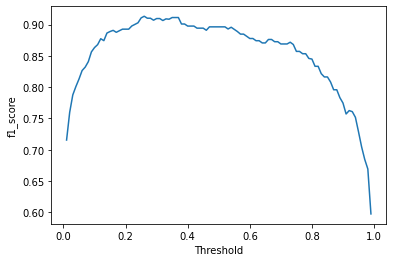

In [53]:
# Find maximum threshold 
threshold = Helper().locate_threshold(model, X_val, y_val)


In [60]:
# output submission
sub = pd.read_csv('sample_submission.csv')
preds = model.predict(vector_test)

if not threshold:
    threshold = 0.3
preds = (preds >= threshold).astype(int)
sub.target = preds
sub.to_csv('submission.csv', index=False)

labels = pd.read_csv('labels.csv').target
print("The submission f1_score is: ", f1_score(labels, preds, average='weighted'))
# !curl -X PUT --upload-file submission.csv ali.140714.xyz:8000/tweets.csv 
# submission result
# GRU 64, max_features = 10000, embed_size=128, max_len=150, no embed, f1_score 0.75460
# GRU 64, max_features = 10000, embed_size=128, max_len=150, no embed, train_size 0.9 (default 0.8), f1_score 0.81083


The submission f1_score is:  0.7818268904232742
